# Figure 1

- Panel (a):  Mr. Pokey, description of experiment P1902
- Panel (b):  Comparison of Kruskal-Wallis and ANOVA F p-values for measuring clonality.
- Panel (c):  UMAP clustering based on all genes, clonal genes, and highly variable genes.
- Panel (d):  Heatmap based on clonal genes.
- Panel (e):  The SVM clonal prediction
- Panel (f):  Accuracy of clonal prediction by linear SVM.
- Panel (g):  Violin plots of six genes, by cells within 9 clones.

# Loading the data

Here we load all the packages that we need, and import the data (pickled by a preprocessing notebook).

## Loading and prepping the packages.

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
from IPython.display import display # Pretty display of data frames.

# Plotting
import matplotlib.pyplot as plt  # For basic plotting.
import matplotlib.transforms as transforms
import matplotlib.colors as pcolors
from matplotlib.patches import Rectangle
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/

# Stats and scipy
import statsmodels.api as sm
import scipy.stats as ss
import scipy.cluster.hierarchy as sch # For hierarchical clustering.


from bisect import bisect # See bisect.bisect.
from itertools import compress # Nice way to apply masks to lists, etc.

# Import from scikit, for machine learning.

from sklearn import base
from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# UMAPs are all the rage... no more tSNE. Sad :(
import umap

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

import anndata

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
mm = 1 / 25.4 # Millimeters

plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

from matplotlib.font_manager import findfont, FontProperties
font = findfont(FontProperties(family=['sans-serif']))

font

'/System/Library/Fonts/Helvetica.ttc'

To create small-image panels for larger figures, we do a bit of extra work.  First, we set some font sizes to 5-7pt, to match the guidelines in *Nature*.

In [3]:
def setfontsize():
    SMALL_SIZE = 6
    MEDIUM_SIZE = 6
    BIGGER_SIZE = 6

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    plt.rcParams['font.sans-serif'] = 'Helvetica'

    plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.

    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

Matplotlib is kind of ridiculous when it comes to actually setting the size of images correctly.  The following solution is from https://kavigupta.org/2019/05/18/Setting-the-size-of-figures-in-matplotlib/.  At least it's close to correct!

In [4]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=300):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=300, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

The following can be useful to check that Helvetica fonts are being used.

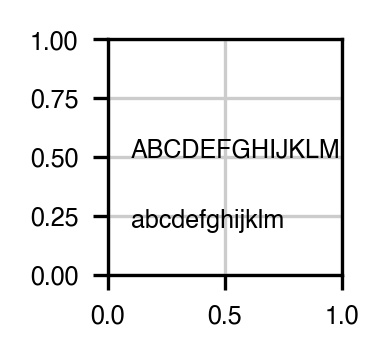

In [5]:
setfontsize()
fig,ax = plt.subplots(1,1,figsize=(1,1), dpi=300)
ax.text(0.1,0.5,'ABCDEFGHIJKLM')
ax.text(0.1,0.2, 'abcdefghijklm')
plt.show()

## Loading the data

Here we load the expression matrices and protein data.

In [6]:
experiment = 'P1902'
file_prefix = '../Data/Processed/'
file_suffix = '.loom'  
datasets = ['invitro','bulks','invivo']
adata = {}
for ds in datasets:
    adata[ds] = anndata.read_loom(file_prefix+experiment+'_'+ds+file_suffix)
    adata[ds].var_names = adata[ds].var['gene_name']
    adata[ds].obs_names = adata[ds].obs['obs_names']

/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
for ds in datasets:
    print('Data for {} loaded'.format(ds))
    print(adata[ds])
    print('------------------------------------')

Data for invitro loaded
AnnData object with n_obs × n_vars = 353 × 9118
    obs: 'Cell_Number', 'Clone_ID', 'Condition', 'Day', 'In_Vivo_Clone_ID', 'Project_ID', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_counts', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'total_counts', 'total_counts_mt'
    var: 'F_pval', 'GC_content', 'K_pval', 'chi2_pval', 'gene_name', 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 'n_cells', 'n_cells_by_counts', 'n_counts', 'on_ratio', 'pathway', 'pct_dropout_by_counts', 'total_counts', 'transcript_length', 'variances', 'variances_norm'
------------------------------------
Data for bulks loaded
AnnData object with n_obs × n_vars = 9 × 7588
    obs: 'Cell_Number', 'Clone_ID', 'Condition', 'Day', 'In_Vivo_Clone_ID', 'Project_ID', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'to

We extract lists of genes, cells, and bulks.  We custom-make the list of clones, to choose their order.

In [8]:
genes = list(adata['invitro'].var_names)  # The names of the genes. 
cells = list(adata['invitro'].obs_names) # The names of the cells.
bulks = list(adata['bulks'].obs_names) # The names of the bulks.

print(adata['invitro'].obs.Clone_ID.unique())

clones = ['H2', 'B4', 'A7', 'G6', 'A8', 'G8', 'H9', 'F3', 'E4'] 
print(clones) # Convenient reordering of clones, MEM then A7 then EFF then E4.


['E4' 'A7' 'A8' 'G6' 'G8' 'H2' 'H9' 'B4' 'F3']
['H2', 'B4', 'A7', 'G6', 'A8', 'G8', 'H9', 'F3', 'E4']


We place this data into new dataframes called X and y, to follow the machine-learning tradition.  X is the feature matrix (gene expressions of each cell) and y has the classes (clonality of each cell).  For permutation tests, we also create a shuffled version of y, with shuffled clone-labels.

In [9]:
X = adata['invitro'].to_df().copy()  # The features.  Copied in memory, just in case.
y = adata['invitro'].obs.Clone_ID # We are trying to predict clonality from the features.
yshuff = pd.Series(np.random.permutation(y.values), index=y.index, name='Clone_ID')

In [10]:
X.head()

gene_name,WASH7P,MTND2P28,hsa-mir-6723,RP5-857K21.7,MTATP8P1,MTATP6P1,RP5-857K21.11,NOC2L,ISG15,RP11-465B22.3,...,TTTY15,USP9Y,DDX3Y,UTY,PSMA6P1,BCORP1,TXLNG2P,KDM5D,EIF1AY,PARP4P1
obs_names,,,,,,,,,,,,,,,,,,,,,
P1902_1289,2.931270,2.828446,1.306369,1.108808,0.0,5.781861,0.000000,0.0,6.884389,0.0,...,0.000000,0.0,0.723545,0.000000,0.0,0.0,0.000000,0.000000,2.792418,0.0
P1902_1290,2.942367,3.935502,0.582051,1.520247,0.0,6.983011,0.000000,0.0,7.427882,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
P1902_1291,0.000000,2.749674,2.199153,1.435323,0.0,5.473203,0.000000,0.0,5.469848,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.766035,0.0
P1902_1293,0.000000,2.940170,2.524608,1.357742,0.0,6.438704,1.029623,0.0,6.994714,0.0,...,0.000000,0.0,0.000000,5.174044,0.0,0.0,0.000000,1.790815,0.000000,0.0
P1902_1294,0.000000,3.788688,0.582189,1.520491,0.0,6.821553,0.000000,0.0,7.290811,0.0,...,5.536519,0.0,0.000000,5.595412,0.0,0.0,5.759866,0.000000,0.000000,0.0


# Gene tranches

In this section, we make tranches of genes based on different properties.  For each tranche, we create a pandas series or dataframe named `XXX_df` with all genes and score(s) reflecting the property.  The dataframe is ordered from most to least, and we pick out the top 100 for a tranche called `genes_XXX`.

## Most variable genes (Suerat v3 method)

In the preprocessing, we used Scanpy's [highly variable genes](https://scanpy.readthedocs.io/en/stable/api/scanpy.pp.highly_variable_genes.html) function, which annotates the highly variable genes using the methods of Seurat v3.  We extract the 100 most variable genes from our data here.

In [11]:
genes_DM = list(adata['invitro'].var.highly_variable_rank.sort_values()[:100].index)
print('The following genes are highly variable:  {}'.format(', '.join(genes_DM)))

The following genes are highly variable:  HIST1H4C, CSF2, EGR1, RRM2, LRRC28, STMN1, IFNG, CCL4L1, TNFRSF9, YWHAQP6, RNU5F-1, IL2RA, BAK1P1, TMEM106A, TK1, KIR2DL4, RPL24P2, HMGB2, TMEM201, PPIAP29, ZWINT, CCL4, ZBED2, RP1-179N16.3, ANKRD42, SEPT7P9, CDC20, FCGR3A, MCM7, SKP1P1, RP11-506M13.3, NPIPA5, AHDC1, RP11-62H7.3, SOX4, AMICA1, KIR3DL1, RP11-1035H13.2, HLA-DRA, ADORA2A, CHAMP1, RP11-767N6.7, CCNB1, RP11-1074O12.1, AARSD1, NR4A2, NDUFA5P11, CCL23, ZNF682, CD200R1, AP000251.3, NUSAP1, CSF1, KLRB1, GTF2H2B, COPRS, AC083899.3, HMGN2, FLT3LG, SLA, C20orf194, LRRC37A, AC098614.2, ZNF320, CBWD3, AC093323.3, NAF1, RP11-277L2.3, ZNF773, NFKBIA, CROCC, FGFBP2, SF3A3P2, KIAA1324, RP5-1073O3.2, AC079949.1, RGPD8, UCP2, RP13-104F24.3, MOGS, AC144530.1, MCM3, HNRNPA1L2, GINS2, KCTD17, TNRC18, TAOK2, ATXN7L3, AC015849.19, MCC, REG4, SH2B1, STAG3L1, LGALS1, HDGFRP2, TOP2A, ZNF787, ANXA1, GSK3A, RRP7B


## Always on genes

Some genes are "always on" -- almost every cell expressed the gene above some minimum threshold.  We pick these out here.

In [12]:
ON_df = pd.Series(adata['invitro'].var['on_ratio'].sort_values(ascending=False))
ON_df.head()

gene_name
RPS19         1.0
MT-ND4        1.0
SERF2         1.0
AC010970.2    1.0
RPS27         1.0
Name: on_ratio, dtype: float64

In [13]:
genes_ON = list(ON_df[:100].index)
print('The following genes are expressed by over {:.1%} cells:  {}'.format(
    ON_df[100], ', '.join(genes_ON)))

The following genes are expressed by over 96.6% cells:  RPS19, MT-ND4, SERF2, AC010970.2, RPS27, ACTB, CCL5, TMSB4X, MT-ND4L, B2M, PFN1, HNRNPH1, MT-CO1, MT-CO3, MALAT1, RPS26, MT-ATP6, MT-CYB, MT-RNR2, MT-CO2, MYL6, SRP14, MYL12A, APOBEC3C, MTATP6P1, ARPC2, IL32, SH3BGRL3, FTL, HNRNPL, EIF5A, RPLP1, ARHGDIB, CAPZA1, GZMB, MT-ATP8, UBB, H3F3B, MT-TE, TMSB4XP1, CD3D, RPL7, TMSB4XP8, MT-RNR1, PFN1P1, RPL41, IL2RG, TMSB10, STK17B, GNLY, SON, NKG7, AC092580.4, MT-ND5, CD3G, CD2, SRGN, RP11-217O12.1, ARF6, SET, LTB, RPL36AL, CFL1, MT-TY, RPS14, ID2, CALR, PPP1CB, TMSB4XP4, TMBIM6, CTNNB1, CALM1, HLA-A, MT-TP, PTPRC, RPL31, HLA-B, RPL21, CCL4, C6orf62, MT-TC, MTA2, CLIC1, YWHAZ, RPS29, IFI6, MT-ND2, GMFG, RPL18A, FTH1, RPL23A, S100A6, CALM2, CD74, DAZAP2, HLA-C, FTLP3, CD52, ATP5L, CST7


## Clonally significant genes

Here we carry out a one-way ANOVA to assign each gene an F-statistic and associated p-value.  We carry this out "from scratch" since we will use the interclonal and intraclonal components of variance later.  The following function carries out the ANOVA and outputs a dataframe.

In [14]:
def ANOVA(gf, grouper):
    N = len(gf)
    grand_mean = gf.mean()
    

    SS_total = (gf - grand_mean)**2 # Total variability as SS.
    SS_total = SS_total.sum() # Total sum of squares.
    
    group_N = grouper.loc[gf.index].value_counts() # Clonal populations.
    num_groups = len(group_N) # Number of clones
    group_means = gf.groupby(grouper).mean() # Means within each clone.
    
    intragroup_SS = gf.groupby(grouper).var() # Use speedy variance function in pandas.
    intragroup_SS = intragroup_SS.apply(lambda col : col * (group_N - 1))
    intragroup_SS = intragroup_SS.sum()
    
    intergroup_SS = (group_means - grand_mean)**2
    intergroup_SS = intergroup_SS.apply(lambda col : col * group_N)
    intergroup_SS = intergroup_SS.sum()
    
    df = pd.DataFrame(index = SS_total.index)
    df['total variance'] = SS_total
    df['interclonal variance'] = intergroup_SS
    df['intraclonal variance'] = intragroup_SS
    df['ANOVA F'] = df['interclonal variance'] / df['intraclonal variance']
    df['ANOVA F'] = df['ANOVA F'] * (N - num_groups) / (num_groups - 1)
    df['p'] = df['ANOVA F'].apply(lambda Fstat : ss.f.sf(Fstat, num_groups - 1, N - num_groups))
    
    return df.sort_values('p')

Carrying out the ANOVA on all 7000+ genes will take a minute or so.

In [15]:
ANOVA_df = ANOVA(X,y)
ANOVA_df.head()

,total variance,interclonal variance,intraclonal variance,ANOVA F,p
gene_name,,,,,
LRRC28,3814.327881,2162.758211,1651.569530,56.309227,4.834800e-58
PLS3-1,1407.182617,769.861183,637.321508,51.942435,9.938219e-55
REG4,1602.109375,854.885504,747.223842,49.195535,1.439467e-52
AMICA1,3817.035645,2027.220052,1789.815662,48.703598,3.562785e-52
AC010970.2,114.213646,53.854502,60.359134,38.366083,2.151638e-43


To double-check, we compare our p-values to those computed by the scipy.stats.f_oneway function during preprocessing.

In [16]:
adata['invitro'].var.F_pval.sort_values().head()

gene_name
LRRC28        4.834792e-58
PLS3-1        9.938207e-55
REG4          1.439458e-52
AMICA1        3.562787e-52
AC010970.2    2.151594e-43
Name: F_pval, dtype: float64

We also carry out the same ANOVA on the data with shuffled clone-labels for later comparison.

In [17]:
ANOVA_df_shuff = ANOVA(X, yshuff)
ANOVA_df_shuff.head()

,total variance,interclonal variance,intraclonal variance,ANOVA F,p
gene_name,,,,,
RNF40,328.132507,32.120330,296.012206,4.665937,0.000020
WDR3,461.982178,42.702022,419.280102,4.379380,0.000047
B3GALTL,685.734375,56.285926,629.448479,3.845104,0.000237
CHAF1B,412.109192,33.574564,378.534611,3.813935,0.000260
MBD2,1026.326660,82.854323,943.472316,3.776195,0.000292


Now we compute the nonparametric analogue of the ANOVA F: the Kruskal-Wallis H statistic.

In [18]:
def KruskalWallis(gf, grouper):
    N = len(gf) # Number of cells
    gf_rank = gf.rank() # Turn gene expressions into ranks, 1...N.
    
    group_N = grouper.loc[gf.index].value_counts() # Clonal populations
    num_groups = len(group_N) # Number of clones.
    
    meanrank = (1+N)/2 # Mean of all the ranks. 
    ties = gf_rank.apply(lambda col : ss.tiecorrect(col)) # Tie correction for Kruskal-Wallis.
    
    gf_rankmean = gf_rank.groupby(grouper).mean() # Compute mean ranks, the \bar r_i.
    scaling = 12 / (ties * N*(N+1))
    
    KW_frame = (gf_rankmean - meanrank).mul(np.sqrt(group_N), axis=0)
    KW_frame = KW_frame * np.sqrt(scaling)
    H = (KW_frame**2).sum(axis=0)
    
    df = pd.DataFrame(index = gf.columns)
    df['Kruskal-Wallis H'] = H 
    df['p'] = ss.distributions.chi2.sf(H, num_groups - 1)
    return df

We compute this for the real clones, and then for the shuffled clone labels.

In [19]:
KW_df = KruskalWallis(X, y)
KW_df.sort_values('p')

,Kruskal-Wallis H,p
gene_name,,
REG4,229.342847,4.078105e-45
LRRC28,209.405546,6.643373e-41
AMICA1,195.206451,6.533031e-38
PLS3-1,189.241839,1.175730e-36
ANXA1,173.144837,2.826171e-33
...,...,...
RPL23AP82,1.151711,9.970963e-01
AFG3L1P,1.082098,9.976746e-01
USP9X,1.071774,9.977530e-01


We compare this to what we computed using scipy.stats.kruskal during preprocessing.

In [20]:
adata['invitro'].var.K_pval.sort_values().head()

gene_name
REG4      4.078105e-45
LRRC28    6.643373e-41
AMICA1    6.533031e-38
PLS3-1    1.175730e-36
ANXA1     2.826171e-33
Name: K_pval, dtype: float64

In [21]:
KW_df_shuff = KruskalWallis(X, yshuff)
KW_df_shuff.sort_values('p')

,Kruskal-Wallis H,p
gene_name,,
MBD2,30.907304,0.000146
PAK2,28.098712,0.000456
WDR3,27.044015,0.000695
CHAF1B,26.874569,0.000743
FEM1C,26.608940,0.000826
...,...,...
IQCB1,0.785508,0.999274
NRAS,0.601534,0.999732
FAM193A,0.598377,0.999737


## Clonally significant on/off genes

Here we select genes based on clonally significant on/off behavior, according to $\chi^2$ statistic.

In [22]:
onoff_df = adata['invitro'].var.chi2_pval.sort_values()
onoff_df.head()

gene_name
PLS3-1         7.763291e-31
REG4           3.870513e-29
LRRC28         2.840224e-22
GPR15          2.589160e-19
RP3-477M7.5    3.704515e-19
Name: chi2_pval, dtype: float64

In [23]:
genes_onoff = list(onoff_df[:100].index)
print('The following genes exhibit on/off behavior:  {}'.format(', '.join(genes_onoff)))

The following genes exhibit on/off behavior:  PLS3-1, REG4, LRRC28, GPR15, RP3-477M7.5, TIMD4, CX3CR1, HPGDS, LGALS3BP, MIR155HG, SLAMF7, RPL38P4, SAMD3, ID3, AMICA1, RP11-465B22.3, CCL20, ANXA1, CD40LG, KLRB1, CADM1, STMN1, S1PR1, SELL, LAIR2, CD300A, GNG8, KLRC3, CD200R1, IFI44L, KLRC2, PER3, DOCK5, ASB2, KLRG1, HDAC9, CCDC50, EPAS1, CCL23, CD9, CCR2, FAM49A, PDE7B, C1orf21, UBA52P5, NT5E, FCGR3A, KLRD1, CSF1, SRRT, PLEK, NCR1, RGS1, KLRC1, PDGFA, LAT2, STEAP1, CXCR6, IKZF2, AOAH, CTSL, BCORP1, EOMES, SGK1, RCBTB2, CCL4L1, CAPG, GZMK, HLA-DRB5, MX1, IL18RAP, ISG20, KIAA0101, CCL4L2, MPZL2, ABCB1, USP18, RP11-291B21.2, PMCH, MKI67, NBPF13P, CLEC7A, CLECL1, HLA-DQB1, CD28, KIR3DL1, CXCR3, LPAR6, ZBTB32, AKR1C3, C3orf14, CCL3L3, RP11-673C5.1, PATL2, LTA, SLC31A2, SPOCK1, HLA-DPA1, RP11-81H14.2, IFITM1


# Clonally significant genes

We have previously computed ANOVA F and Kruskal-Wallis H-statistics for our genes, based on our clonal groups and a shuffled version for comparison.  In this panel, we use this to count and identify the differentially expressed genes.

/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


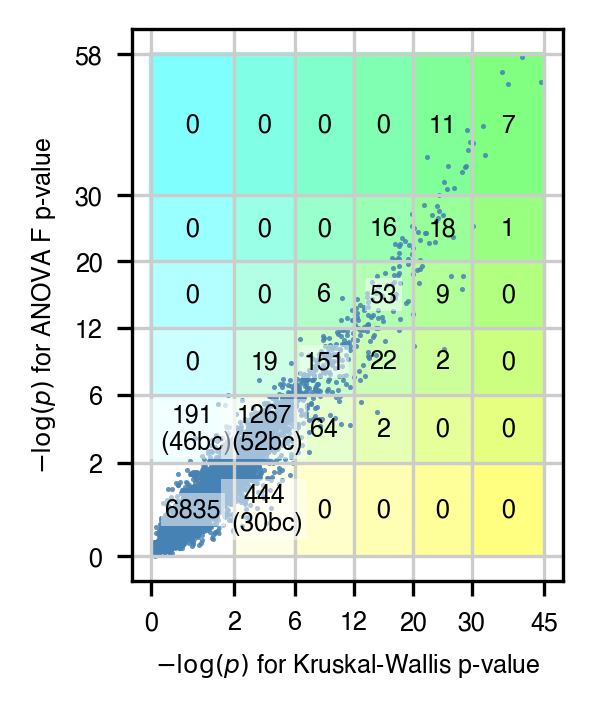

In [24]:


fig, ax = plt.subplots(figsize=(50*mm,60*mm), dpi=300)
setfontsize()

H_logp = -np.log10(KW_df['p'])
F_logp = -np.log10(ANOVA_df['p'])

H_logp_shuff = -np.log10(KW_df_shuff['p'])
F_logp_shuff = -np.log10(ANOVA_df_shuff['p'])

H_allmax = H_logp.max()
F_allmax = F_logp.max()

Hcuts = [0,2,6,12,20,30,int(np.ceil(H_allmax))]
Fcuts = [0,2,6,12,20,30,int(np.ceil(F_allmax))]

sqrtHcuts = [np.sqrt(x) for x in Hcuts]
sqrtFcuts = [np.sqrt(y) for y in Fcuts]

ax.set_xticks(sqrtHcuts)
ax.set_xticklabels(Hcuts)

ax.set_yticks(sqrtFcuts)
ax.set_yticklabels(Fcuts)

for i in range(len(Fcuts) - 1):
    for j in range(len(Hcuts) - 1):
        Fmin, Fmax = sqrtFcuts[i], sqrtFcuts[i+1]
        Hmin, Hmax = sqrtHcuts[j], sqrtHcuts[j+1]
        color = (1-i*0.1,1,1-j*0.1)
        #labcolor = (i*0.1, 0, j*0.1)
        labcolor = (0,0,0)
        gene_FH = [gene for gene in genes if H_logp[gene] >= Hcuts[j] and H_logp[gene] < Hcuts[j+1] and
                  F_logp[gene] >= Fcuts[i] and F_logp[gene] < Fcuts[i+1]]
        
        gene_FH_shuff = [gene for gene in genes if H_logp_shuff[gene] >= Hcuts[j] and H_logp_shuff[gene] < Hcuts[j+1] and
                  F_logp_shuff[gene] >= Fcuts[i] and F_logp_shuff[gene] < Fcuts[i+1]]
        
        left, width = Hmin, Hmax-Hmin
        bottom, height = Fmin, Fmax-Fmin
        right = left + width
        top = bottom + height
        ax.add_patch(plt.Rectangle((left,bottom), width, height, zorder=-2, color=color))
        offset = 0
        if len(gene_FH) == 1:
            plural = ''
        else:
            plural = 's'
        label = '{}'.format(len(gene_FH))
        if (0 < len(gene_FH_shuff) < 5000):
            label += '\n ({}bc)'.format(len(gene_FH_shuff))
        #if (i == j) and (i > 2):
        #    labcolor = (1,0.2,0.2)
        if ((i == j) and (i < 4)) or ((i < 2) and (j < 2)):
            bbox = dict(facecolor='white', edgecolor=None, linewidth=0, alpha=0.5, pad=1.0)
        else:
            bbox = None
        ax.text(0.5 * (left + right), 0.5 * (bottom + top) - offset, label,
                horizontalalignment='center',
                verticalalignment='center', color = labcolor, 
                bbox=bbox)

sns.scatterplot(np.sqrt(H_logp), np.sqrt(F_logp), ax=ax, color='steelblue', s=1.5, linewidth=0,
                edgecolor = None, alpha=0.85, legend=None) #color=(1,0.9,0.9))
ax.set_xlabel('$-\log(p)$ for Kruskal-Wallis p-value')
ax.set_ylabel('$-\log(p)$ for ANOVA F p-value')

sig_genes = [gene for gene in genes if H_logp[gene] > 2 and F_logp[gene] > 2]
sig_genes_shuff = [gene for gene in genes if H_logp_shuff[gene] > 2 and F_logp_shuff[gene] > 2]

plt.suptitle('') #Clonally significant genes,\n by ANOVA F and Kruskal-Wallis H.')        

set_size(fig, (50*mm, 60*mm))
plt.savefig("Panels/FH_genes.pdf", bbox_inches='tight')
               
plt.show()

##  Visualizing gene tranches.

In [25]:
genes_sig2 = [gene for gene in genes if (H_logp[gene] > 2) and (F_logp[gene] > 2)]
print('{} genes meet the p<0.01 threshold for both F and H statistics'.format(len(genes_sig2)))

genes_sig2_shuff = [gene for gene in genes if (H_logp_shuff[gene] > 2) and (F_logp_shuff[gene] > 2)]
print('{} genes found by chance'.format(len(genes_sig2_shuff)))

1648 genes meet the p<0.01 threshold for both F and H statistics
52 genes found by chance


In [26]:
genes_sig6 = [gene for gene in genes if (H_logp[gene] > 6) and (F_logp[gene] > 6)]
print('{} genes meet the p < 1e-6 threshold for both F and H statistics'.format(len(genes_sig6)))

genes_sig6_shuff = [gene for gene in genes if (H_logp_shuff[gene] > 6) and (F_logp_shuff[gene] > 6)]
print('{} genes found by chance'.format(len(genes_sig6_shuff)))

296 genes meet the p < 1e-6 threshold for both F and H statistics
0 genes found by chance


In [27]:
genes_sig12 = [gene for gene in genes if (H_logp[gene] > 12) and (F_logp[gene] > 12)]
print('{} genes meet the p<1e-12 threshold for both F and H statistics'.format(len(genes_sig12)))

genes_sig12_shuff = [gene for gene in genes if (H_logp_shuff[gene] > 12) and (F_logp_shuff[gene] > 12)]
print('{} genes found by chance'.format(len(genes_sig12_shuff)))

115 genes meet the p<1e-12 threshold for both F and H statistics
0 genes found by chance


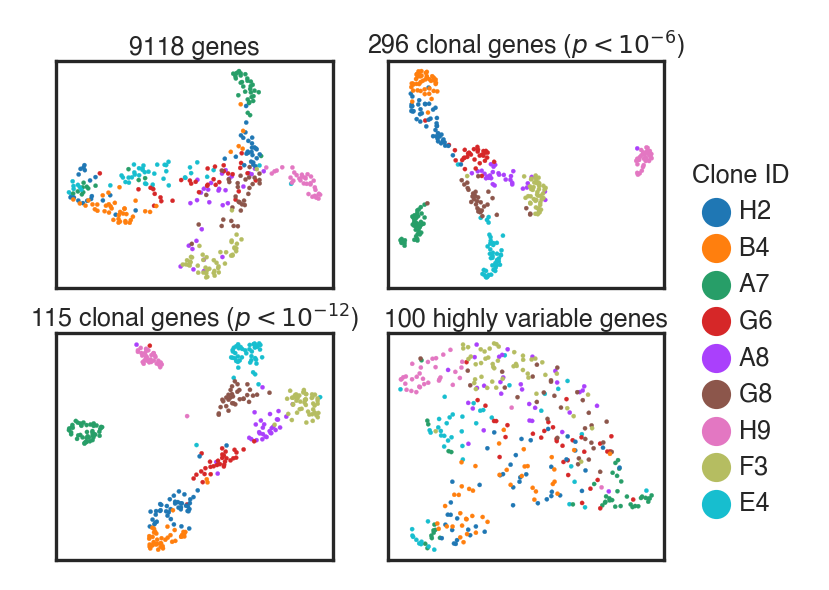

In [28]:
sns.set_style("white")

tranches = {'genes': genes,
           'clonal genes ($p<10^{-6}$)' : genes_sig6,
           'clonal genes ($p<10^{-12}$)' : genes_sig12,
           'highly variable genes' : genes_DM}

no_cuts = len(tranches)

n_components = 10
n_neighbors = 30
min_dist = 0.2

fig, ax = plt.subplots(2,2,figsize=(70*mm,50*mm), dpi=300)
setfontsize()

j = 0
for tranch in tranches:
    genelist = tranches[tranch]
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X[genelist]) # Apply PCA with 10 components.
    X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                           random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

    cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
    cl_df['Clone'] = ' ' + y
    hue_order = [' ' + clone for clone in clones]

    #sns.set(rc={'figure.figsize':(7,7)})
    if j != 1:
        sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', hue_order = hue_order, data = cl_df, 
                        s=1, edgecolor=None,
                        legend = None, ax=ax[j//2,j%2])
    else:
        g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', hue_order = hue_order, data = cl_df, 
                            s=1, edgecolor=None, ax=ax[j//2,j%2])
        #g.legend().get_frame().set_linewidth(0.0)
        g.legend(loc='upper left', bbox_to_anchor=(1.02, 0.65), ncol=1, title='Clone ID', 
                 framealpha=0.0)
        
    
    ax[j//2,j%2].set_title("{} {}".format(len(genelist), tranch),y=0.92)
    #if j > 0:
    #    ax[j].yaxis.label.set_visible(False)
    ax[j//2,j%2].get_xaxis().set_visible(False) 
    ax[j//2,j%2].get_yaxis().set_visible(False)
    j += 1
    
#plt.suptitle("UMAP clustering on {} PCs. \n "
#             "(neighbors = {}, min dist = {}, cos metric)".format(n_components, n_neighbors, min_dist), 
#            y=1.05)

set_size(fig, (70*mm, 50*mm))
plt.savefig("Panels/UMAPs.pdf", bbox_inches='tight')

plt.show()



Clones B4 and H2 seem hardest to separate.  They are both MEM-type clones, so their gene expression profiles may naturally be closer to each other.  Note that using just the most variable genes is *not* a very good way of finding the clones!

# Clonal proportion of variance

Let's take another look at our ANOVA dataframe.

In [29]:
ANOVA_df.head()

,total variance,interclonal variance,intraclonal variance,ANOVA F,p
gene_name,,,,,
LRRC28,3814.327881,2162.758211,1651.569530,56.309227,4.834800e-58
PLS3-1,1407.182617,769.861183,637.321508,51.942435,9.938219e-55
REG4,1602.109375,854.885504,747.223842,49.195535,1.439467e-52
AMICA1,3817.035645,2027.220052,1789.815662,48.703598,3.562785e-52
AC010970.2,114.213646,53.854502,60.359134,38.366083,2.151638e-43


For each gene, we can compute its $\eta^2$ statistic, which is the ratio (interclonal variance) / (total variance).  For any *set* of genes, we compute something analogous:  the (total interclonal variance) / (total total variance).  The following function computes this gene-set $\eta^2$ statistic, using the real clone labels by default, and our shuffled clone labels for comparison (by setting `shuff` to `True`). 

In [30]:
def clonal_proportion(genelist, shuff=False):
    if shuff:
        sums = ANOVA_df_shuff.loc[genelist].sum()
    else:
        sums = ANOVA_df.loc[genelist].sum()
    return sums['interclonal variance'] / sums['total variance']

We plot the clonal proportion of variance for some of our gene tranches.  We compare to the chance outcomes (shuffled clone labels) as well.

In [31]:
adata['invitro'].var.loc[genes_sig6, ['F_pval','highly_variable_rank','on_ratio']].to_csv('Genelists/genes_sig6.csv')
adata['invitro'].var.loc[genes_sig12, ['F_pval','highly_variable_rank','on_ratio']].to_csv('Genelists/genes_sig12.csv')
adata['invitro'].var.loc[genes_ON, ['F_pval','highly_variable_rank','on_ratio']].to_csv('Genelists/genes_ON.csv')
adata['invitro'].var.loc[genes_DM, ['F_pval','highly_variable_rank','on_ratio']].to_csv('Genelists/genes_variable.csv')

<ipython-input-32-a69c1215ad78>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


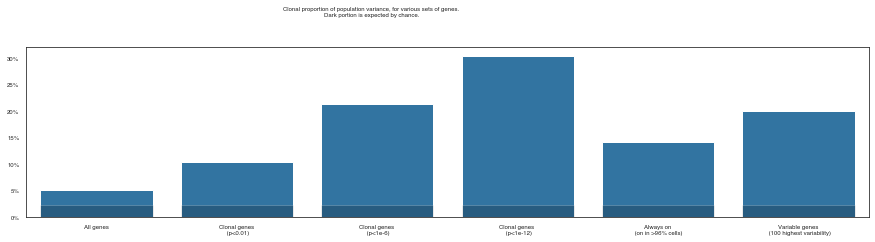

In [32]:
tranches = {'All genes' : genes,
           'Clonal genes \n (p<0.01)' : genes_sig2,
           'Clonal genes \n (p<1e-6)' : genes_sig6,
           'Clonal genes \n (p<1e-12)' : genes_sig12,
           'Always on \n (on in >96% cells)' : genes_ON,
           #'Bursty genes \n (on in <5% cells \n in at least 1 clone)' : genes_bursty,
           'Variable genes \n (100 highest variability)' : genes_DM} #,
           #'MT-genes' : gene_paths['MT-genes'],
           #'Ribosomal \n Processes' : gene_paths['Ribosomal Processes'],
           #'Mitochondrial \n Respiration \n (non-MT-genes)' : gene_paths['Mitochondrial Respiration']}

x_list = list(tranches.keys())
y_list = [clonal_proportion(tranches[tranch]) for tranch in tranches.keys()]
y_list_shuff = [clonal_proportion(tranches[tranch], shuff=True) for tranch in tranches.keys()]

fig,ax = plt.subplots(figsize = (15,3))

sns.barplot(x=x_list, y=y_list, color = 'tab:blue')
sns.barplot(x=x_list, y=y_list_shuff, color='black', alpha=0.2)

plt.suptitle('Clonal proportion of population variance, for various sets of genes. \n'
             'Dark portion is expected by chance.', y=1.1)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

plt.show()

# SVM classification

The clustering makes it clear that differentially expressed genes can be used to separate clones.  A priori, this might be a case of overfitting -- with 9000+ genes and 9 clusters, perhaps it is not surprising that clonal information can be used to choose genes, which then can be used to separate clones.

In this section, we follow the typical supervised machine learning workflow -- dividing the data into training and testing sets, and using the gene expression profiles of training cells (with clonality) to train a classifier to predict clonality of testing cells.  We use a linear SVM classifier below.  We also tried Bernoulli and Gaussian naive Bayesian classifiers, but SVM worked best (with Bernoulli naive Bayes a close second).

## Visualization functions

We create some general-purpose functions for visualization below.

In [33]:
def CV_map(gs, swap=False, savefig=False):  # parameter_grid and grid_search.
    '''
    A general-purpose visualization for grid-search cross-validations.
    Displays predictive accuracy as a heatmap, based on different
    choices of parameters.  Displays optimal parameters in title.
    
    Args:
        gs (sklearn.model_selection.GridSearchCV):  The grid-search object.
        swap:  Set to True to switch the axes.
        
    Returns:
        None
        
    '''
    results = gs.cv_results_
    means = results['mean_test_score']
    params = list(gs.param_grid.keys())
    
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in results['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    if swap:
        gs_df = gs_df.transpose()
        params = params[::-1] # Switch the order of the parameter list.
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(params[1])
    ax.set_ylabel(params[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with 5-fold cross-validation. \n"
                 "Best score {0:2.1%} with parameters \n"
                 "{1} ".format(gs.best_score_, gs.best_params_))
    if savefig:
        plt.savefig('CV_map.svg')

In [34]:
def confusion_matrix(X,y,pipe, reps=2, classlist = None, filename=None):
    if classlist:
        classes = classlist
    else:
        classes = sorted(y.unique())
    counts = pd.DataFrame(0, index=classes, columns=classes)
    cpops = pd.DataFrame(0, index=classes, columns=['pop'])
    correct = 0
    total = 0
    for t in range(reps):
        this_pipe = base.clone(pipe)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        this_pipe.fit(X_train, y_train)
        y_pred = this_pipe.predict(X_test)
        actual = y_test
        predicted = y_pred
        for j in range(len(y_test)):
            total += 1
            if y_test[j] == y_pred[j]:
                correct += 1
            cpops.loc[y_test[j],'pop'] += 1
            counts.loc[y_test[j], y_pred[j]] += 1
    
    valid = counts.apply(lambda column : column/cpops['pop']) #['pop'] )
    valid_dec = (valid*100).astype(int)
    
    #f, ax = plt.subplots(figsize=(8,7))
    f, ax = plt.subplots(figsize=(30*mm,32*mm), dpi=300)
    setfontsize()
    #fmt="2.0%"
    sns.heatmap(valid, annot=valid_dec, annot_kws={'fontsize':5}, fmt="d", square=True, linewidths=.25, cbar=None,
                cbar_kws={'fraction':0.02, 'pad':0.02}, ax=ax)
    #cbar = ax.collections[0].colorbar
    #cbar.set_ticks([0, .25, .5, .75, 1])
    #cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_xticks([])
    ax.set_yticks([])
    tickypos = -0.3
    pal = sns.color_palette()
    lut = dict(zip(classes, pal))
    for j,cl in enumerate(classes):
        ax.add_patch(Rectangle((tickypos,j+0.1),0.3,0.8, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((j+0.1,tickypos),0.8,0.3, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((len(classes)-tickypos,j+0.1),-0.3,0.8, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((j+0.1,len(classes)-tickypos),0.8,-0.3, color=lut[cl],fill=True,clip_on=False))
    ax.set_ylabel("Actual clone")
    ax.set_xlabel("Predicted clone")
    ax.set_title("Predicted clonality (%).".format(correct / total))
    
    if filename:
        set_size(f, (30*mm, 32*mm))
        plt.savefig(filename, bbox_inches='tight')
    # "{} trials, in {} batches with independent splits.".format(correct/total, total, reps))

In [35]:
def sort_by(df, col, valuelist):
    '''
    Sorts a data frame, according to the values in a column,
    and a chosen order for these values.
    '''
    if set(df[col].unique()) != set(valuelist):
        print('Warning, cannot sort!')
        return df
    value_dict = {valuelist[j]:j for j in range(len(valuelist))}
    df['newcol'] = df[col].apply(lambda v : value_dict[v])
    df.sort_values('newcol', inplace=True)
    df.drop('newcol', axis=1)
    return df

In [36]:
#  DANGER DANGER!  The lines below ignore all warnings.
#  It's nice to avoid all the convergence warnings.  
#  But dangerous in general.
import warnings
warnings.filterwarnings("ignore")
#  End of warning.... proceed below.

SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=110)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=1.0, max_iter=2000)) ])

param_grid = dict(skb__k = [2,5,10,20,30,50,75,100,125,150,200,250,300], svm__C = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0])

grid_search = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=5) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mm', MinMaxScaler()),
                                       ('skb', SelectKBest(k=110)),
                                       ('svm',
                                        LinearSVC(max_iter=2000,
                                                  random_state=0))]),
             param_grid={'skb__k': [2, 5, 10, 20, 30, 50, 75, 100, 125, 150,
                                    200, 250, 300],
                         'svm__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})

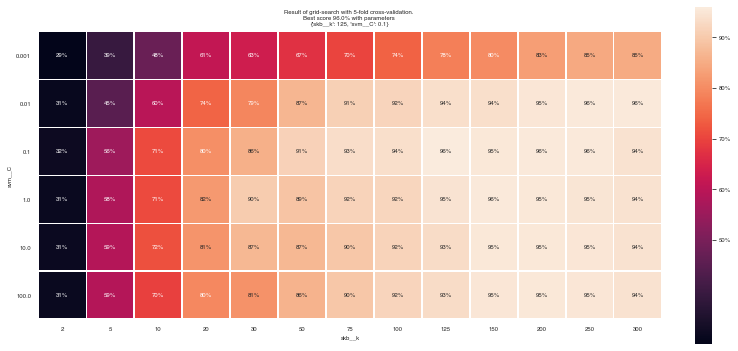

In [37]:
CV_map(grid_search, swap=True)

## Panel:  Confusion matrix.

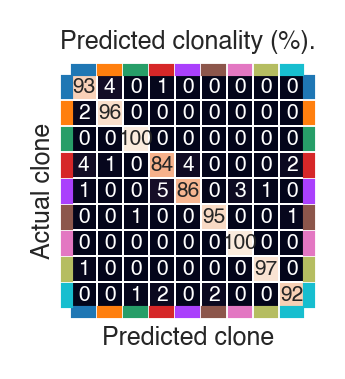

In [38]:
opt_k = grid_search.best_params_['skb__k'] # Use optimal number of genes.
opt_C = grid_search.best_params_['svm__C'] # Use optimal C-parameter for linear SVM.

SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=opt_k), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000, C=opt_C))

confusion_matrix(X,y,SVMpipe, reps=100, classlist = clones, filename='Panels/Confusion.pdf')

## Panel:  Accuracy of SVM prediction.

In [39]:
k_testlist = list(range(1,10)) + list(range(10,20,2)) + list(range(20,40,5)) + list(range(40,90,10)) + list(range(100,200,25)) + list(range(200,400,50)) + list(range(400,801,100))
SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=110)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=0.1, max_iter=2000)) ])

param_grid = dict(skb__k = k_testlist, svm__C = [0.1])

grid_search = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=5) #5-fold cross-validation.
grid_search.fit(X,y)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mm', MinMaxScaler()),
                                       ('skb', SelectKBest(k=110)),
                                       ('svm',
                                        LinearSVC(C=0.1, max_iter=2000,
                                                  random_state=0))]),
             param_grid={'skb__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16,
                                    18, 20, 25, 30, 35, 40, 50, 60, 70, 80, 100,
                                    125, 150, 175, 200, 250, 300, ...],
                         'svm__C': [0.1]})

In [40]:
SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=110)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=0.1, max_iter=2000)) ])

param_grid = dict(skb__k = k_testlist, svm__C = [0.1])

grid_search_shuff = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=5) #5-fold cross-validation.
grid_search_shuff.fit(X,yshuff)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mm', MinMaxScaler()),
                                       ('skb', SelectKBest(k=110)),
                                       ('svm',
                                        LinearSVC(C=0.1, max_iter=2000,
                                                  random_state=0))]),
             param_grid={'skb__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16,
                                    18, 20, 25, 30, 35, 40, 50, 60, 70, 80, 100,
                                    125, 150, 175, 200, 250, 300, ...],
                         'svm__C': [0.1]})

In [41]:
CV_df = pd.DataFrame()
for split in range(5):
    split_string = 'split'+str(split)+'_test_score'
    CV_df[split] = grid_search.cv_results_[split_string]
CV_df['Number of genes'] = grid_search.cv_results_['param_skb__k'].data
CV_df['Clonal prediction accuracy'] = grid_search.cv_results_['mean_test_score']

CV_df.head()
CV_melt = pd.melt(CV_df, id_vars='Number of genes', value_vars=[0,1,2,3,4], value_name='Clonal prediction accuracy')
CV_shuff = pd.DataFrame()
CV_shuff['Number of genes'] = grid_search_shuff.cv_results_['param_skb__k'].data
CV_shuff['Clonal prediction accuracy'] = grid_search_shuff.cv_results_['mean_test_score']

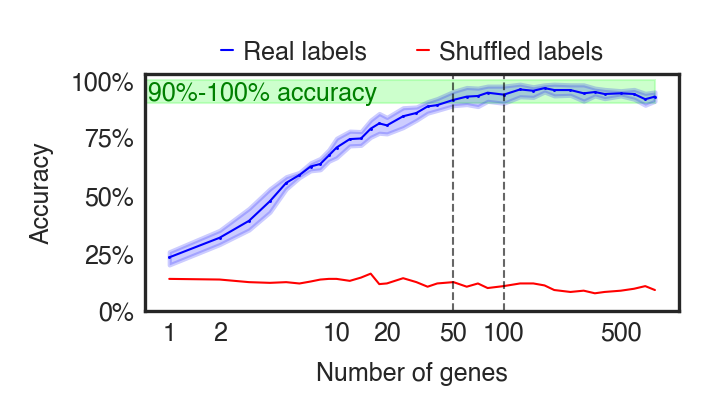

In [42]:
#fig,ax = plt.subplots(figsize = (20,6))
f, ax = plt.subplots(figsize=(60*mm,35*mm), dpi=300)


sns.set_style("white")
setfontsize()

sns.lineplot(x = 'Number of genes', y = 'Clonal prediction accuracy', data=CV_melt,
            color='blue', label='Real labels', linewidth=0.5)

sns.scatterplot(x = 'Number of genes', y = 'Clonal prediction accuracy', data=CV_df, 
                color='blue', s=0.5, linewidth=0)

sns.lineplot(x = 'Number of genes', y = 'Clonal prediction accuracy', data=CV_shuff, 
             color='red', label='Shuffled labels', linewidth=0.5)

ax.set_xscale('log')
ax.set_yticks(np.linspace(0.0,1.0,5))

#ax.yaxis.set_label_position("right")

vals = ax.get_yticks()
ax.set_yticklabels(['{:1.0%}'.format(y) for y in vals])
ax.set_ylabel('Accuracy')

ax.set_xticks([1,2,10,20,50,100,500])
vals = ax.get_xticks()
ax.set_xticklabels(['{}'.format(x) for x in vals])

ax.tick_params(axis='both', which='major', pad=-1)


ax.add_patch(plt.Rectangle((0,0.9), 800, 0.1, zorder=0, color=(0.5,1,0.5,0.4), linewidth=0.5))
ax.text(0.75, 0.91, '90%-100% accuracy', color='green', ha='left')

ax.axvline(50, linestyle='--', linewidth=0.5, color='k', alpha=0.6) # vertical lines
ax.axvline(100, linestyle='--', linewidth=0.5, color='k', alpha=0.6) # vertical lines

plt.legend(bbox_to_anchor=(0.5, 1), loc='lower center', borderaxespad=0., ncol=2, frameon=False)

#plt.suptitle('Accuracy of clonal prediction by linear SVM.', y=1.1)# \n'
         #    'SVM penality parameter fixed at C = 0.1. \n'
         #   'Linear SVM restricted to {} -- {} most significant genes'.format(vals[0], vals[-1]), y=1.0)

set_size(f, (60*mm, 35*mm))
plt.savefig('Panels/SVM_graph.pdf', bbox_inches='tight')
    
plt.show()


# Heatmaps for DE genes

Here we have some general purpose functions for heatmaps, including miniature versions for small panels.

In [43]:
def miniminiheat(ef, mf, genelist, prop='Clone_ID', classlist = clones, filename=None, hpush = 0):
    '''
    Visualizes gene expression across cells.
    
    Args:
        ef (pandas dataframe):  The gene expression matrix.
        mf (pandas dataframe:  The metadata dataframe.
        genelist (list): The list of genes to visualize.
        prop:  A column of the metadata, e.g. Clone_ID.  Place cells in blocks according to this.
        classlist:  Custom sort Clone_ID (or whatever prop) according to this list.
        filename:  If given, the filename to save the figure, e.g. 'heatmap.pdf'
        
    Returns:
        None.  Just makes a pretty picture.
        
    
    '''
    genelist = [gene for gene in genelist if gene in ef.columns]
    df = ef[genelist].copy()
    
    #genelist = gene_names[genelist] # Human-readable names.
    #df.columns = genelist
    
    df[prop] = mf[prop]
    df_cl = df.groupby(prop).mean()
    df = sort_by(df, prop, classlist)
    
    # Sort genes by markers of clones.
    marker_list = []
    df_cl = df.groupby(prop).mean()
    for cl in df[prop].unique():
        markers = [gene for gene in genelist if df_cl[gene].max() == df_cl[gene][cl]]
        marker_list += markers
    genelist = marker_list
    
    # Final dataframe and metadata for plot.
    df = df[genelist]
    md = mf.loc[df.index]

    # Create plot.
    
    # Set (small) figure size and fonts
    # figsize=(1.2,1.25)
    figsize=(30*mm,30*mm)
    
    sns.set_style("white")
    setfontsize()
    
    
    # Create colors for clones (or whatever classes)
    #pal = sns.cubehelix_palette(len(classlist),light=.9, dark=.1, reverse=True, start=1, rot=-2)
    pal = sns.color_palette()
    #pal = sns.color_palette("hls", len(classlist))
    lut = dict(zip(classlist, pal))
    colors = pd.Series(md[prop]).map(lut)
    colors.name = None
    
    cg = sns.clustermap(df[genelist].transpose(), z_score=0, cmap="coolwarm", vmin=-2, vmax=2, 
                        col_colors=colors.values, figsize=figsize, col_cluster=False, row_cluster=False,
                        dendrogram_ratio=(0.001,0.001), colors_ratio=0.05)
        
    
    cg.fig.set_dpi(300)
    cg.cax.remove()
    
    ax = cg.ax_heatmap # Main heatmap axis.
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_xticklabels([])
    
    
    # Figure title
    figtitle = '{} metagenes'.format(len(genelist))
    plt.suptitle(figtitle, x=0.25, y=0.95)   
    
    if filename:
        #plt.savefig(filename, pad_inches = 0, dpi = 300)
        set_size(cg.fig, (30*mm, 30*mm))
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

In [44]:
def new_miniheat(ef, mf, genelist, prop='Clone_ID', classlist = clones, filename=None, hpush = 0):
    '''
    Visualizes gene expression across cells.
    
    Args:
        ef (pandas dataframe):  The gene expression matrix.
        mf (pandas dataframe:  The metadata dataframe.
        genelist (list): The list of genes to visualize.
        prop:  A column of the metadata, e.g. Clone_ID.  Place cells in blocks according to this.
        classlist:  Custom sort Clone_ID (or whatever prop) according to this list.
        filename:  If given, the filename to save the figure, e.g. 'heatmap.pdf'
        
    Returns:
        None.  Just makes a pretty picture.
        
    
    '''
    genelist = [gene for gene in genelist if gene in ef.columns]
    df = ef[genelist].copy()
    
    #genelist = gene_names[genelist] # Human-readable names.
    #df.columns = genelist
    
    df[prop] = mf[prop]
    df_cl = df.groupby(prop).mean()
    df = sort_by(df, prop, classlist)
    
    # Sort genes by markers of clones.
    marker_list = []
    df_cl = df.groupby(prop).mean()
    for cl in df[prop].unique():
        markers = [gene for gene in genelist if df_cl[gene].max() == df_cl[gene][cl]]
        marker_list += markers
    genelist = marker_list
    
    # Final dataframe and metadata for plot.
    df = df[genelist]
    md = mf.loc[df.index]

    # Create plot.
    
    # Set (small) figure size and fonts
    f, ax = plt.subplots(2,1,figsize=(50*mm,60*mm), dpi=300,
                        gridspec_kw={'height_ratios':[1,15],
                                    'hspace':0.01},
                        sharex=True)
    
    sns.set_style("white")
    setfontsize()
    
    
    # Create colors for clones (or whatever classes)
    #pal = sns.cubehelix_palette(len(classlist),light=.9, dark=.1, reverse=True, start=1, rot=-2)
    pal = sns.color_palette()
    #pal = sns.color_palette("hls", len(classlist))
    lut = dict(zip(classlist, pal))
    colors = pd.Series(md[prop]).map(lut)
    colors.name = 'Clone ID'
    
    df_z = df[genelist]
    df_z = (df_z - df_z.mean()) / df_z.std()
    
    sns.heatmap(df_z.T, cmap="coolwarm", vmin=-2, vmax=2, ax=ax[1], cbar=False)
    
    ax[1].set_xticklabels([])
    ax[1].set_yticklabels([])
    ax[1].set_xlabel('')
    ax[1].set_ylabel('')
    
    clone_pops = md.value_counts()
    x_cl = 0
    for cl in clones:
        cl_pop = clone_pops[cl]
        ax[0].add_patch(plt.Rectangle((x_cl,0), cl_pop, 1, color=lut[cl], alpha=0.5))
        ax[0].text(x_cl + 0.5*cl_pop, 0.5, cl, ha='center', va='center')
        x_cl += cl_pop
        
    ax[0].set_yticklabels([])
    #ax[0].set_title('Clone ID',y=0.95)
    [s.set_visible(False) for s in ax[0].spines.values()]
    
    plt.suptitle('{} clonal genes, {} clones'.format(len(genelist),len(classlist)), y=0.95)
    set_size(f, (50*mm, 60*mm))
    plt.savefig('Panels/Heatmap_new.pdf', bbox_inches='tight')
    
    plt.show()

Now we create a heatmap for the genes which meet the p<1e-12 threshold.

In [45]:
meta_df = pd.DataFrame(y)
meta_df.columns = ['Clone_ID']

In [46]:
clone_type = pd.CategoricalDtype(categories=clones, ordered=True)

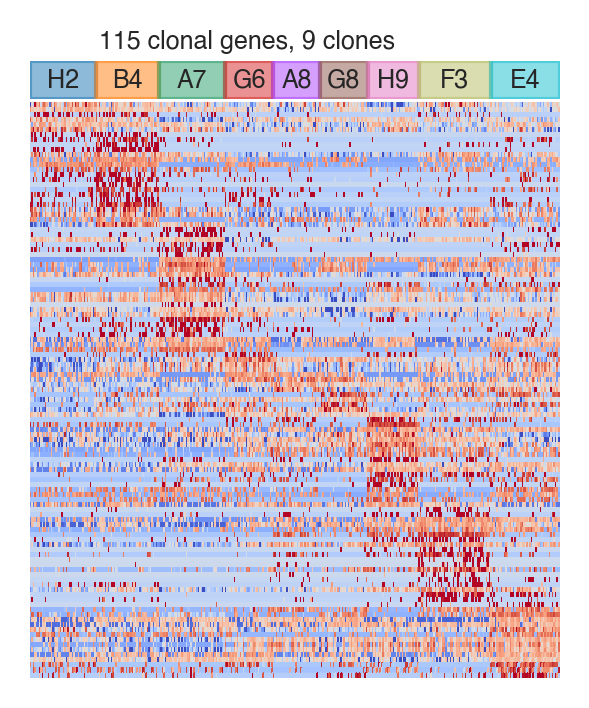

In [47]:
new_miniheat(X, meta_df, genes_sig12, hpush=-0.02, filename='Panels/Heatmap.pdf')

Next, we make a heatmap for "metagenes" created by a LinearSVM.  Note that this is just to help the reader understand the LinearSVM.  The *actual* metagenes are created repeatedly, using only the training sets, as the SVM classifier is trained and cross-validated.  There should be no actual claim of robustness of particular metagenes!

In [48]:
SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=50)),
                     ('svm', LinearSVC(C = 0.1)) ])

SVM_pipe.fit(X,y)
skbf = SVM_pipe.named_steps['skb']
lsvc = SVM_pipe.named_steps['svm']

diff_genes = list(compress(genes, skbf.get_support())) # differentially-expressed genes by ANOVA F
print('The {} differentially expressed genes (selected by ANOVA F) are: {}'.format(
    len(diff_genes),', '.join(diff_genes)))

The 50 differentially expressed genes (selected by ANOVA F) are: RP3-477M7.5, CSF1, CD2, REG4, SLAMF7, IFITM1, MALAT1, CADM1, AMICA1, LAG3, KLRB1, KLRD1, KLRC3, KLRC2, KLRC1, ALOX5AP, B2M, LRRC28, IL32, CCL5, CCL4, CCL3L3, CCL4L1, CCL3L1, CCL4L2, LGALS3BP, FTL, LAIR2, PLEK, TMSB10P1, MIR155HG, CX3CR1, CXCR6, RPL38P4, GPR15, HPGDS, CD74, TIMD4, HLA-DRB5, SAMD3, PDGFA, ACTB, GIMAP4, DOCK5, ANXA1, RP11-217O12.1, MT-TN, PLS3-1, CD40LG, AC010970.2


In [49]:
def make_metagene(coef_list, g_list):
    '''
    Represents SVC coefficients as a metagene, including both coefficients and genes.
    Metagenes are represented as Python dictionaries, with keys=genes, values=coefficients.
    '''
    return dict(zip(g_list, coef_list))

In [50]:
metagenes = [ make_metagene(coef_list, diff_genes) for coef_list in lsvc.coef_ ]

In [51]:
metagene_df = pd.DataFrame(index=diff_genes, columns=lsvc.classes_)
j = 0
for c in metagene_df.columns:
    metagene_df[c] = metagenes[j].values()
    j += 1
metagene_df = metagene_df[clones] # Reorder columns to preferred order of clones.
metagene_df.head()

,H2,B4,A7,G6,A8,G8,H9,F3,E4
RP3-477M7.5,0.171979,0.264188,-0.215320,-0.324362,-0.028911,-0.071390,-0.071848,-0.049168,-0.043230
CSF1,-0.206772,-0.105163,-0.107055,-0.079639,0.490782,0.074424,-0.250117,-0.028968,0.210887
CD2,0.239502,-0.209255,-0.374773,-0.212913,-0.079302,-0.183619,-0.089731,-0.171928,-0.116213
REG4,0.013561,0.590329,-0.055921,-0.346743,-0.154759,-0.192362,-0.110927,-0.123174,-0.104872
SLAMF7,-0.183880,-0.049831,0.325223,0.137777,-0.135413,-0.470651,-0.136065,-0.041342,0.415064


In [52]:
def add_metas(ge, mg_df):
    #df = pd.DataFrame(index=ge.index, columns=mg_df.columns)
    df = ge[mg_df.index].dot(mg_df)
    df.columns = [c + ' Metagene' for c in df.columns]
    return df

In [53]:
EM_metagene = add_metas(X, metagene_df)
EM_metagene.head()

,H2 Metagene,B4 Metagene,A7 Metagene,G6 Metagene,A8 Metagene,G8 Metagene,H9 Metagene,F3 Metagene,E4 Metagene
obs_names,,,,,,,,,
P1902_1289,-17.727654,-8.750355,-11.520293,-11.621632,-12.715411,-5.828600,-12.165926,-14.902556,-0.501345
P1902_1290,-21.027800,-9.479746,-15.483790,-13.868878,-7.614866,-5.237633,-9.139575,-8.337643,-3.061967
P1902_1291,-23.010185,-9.808714,-7.832664,-15.328808,-17.703242,-7.147272,-12.925449,-9.524533,1.259618
P1902_1293,-16.201879,-11.172610,6.045873,-10.260772,-17.857431,-9.200266,-7.306048,-13.640377,-11.156149
P1902_1294,-11.971036,-11.633371,1.969103,-12.264994,-14.124397,-9.106905,-9.529737,-11.959221,-10.725275


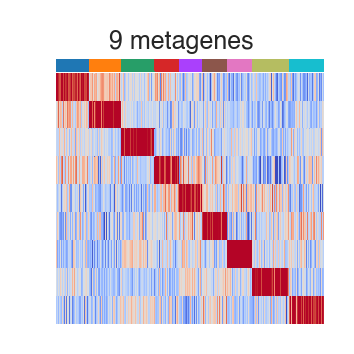

In [54]:
miniminiheat(EM_metagene, meta_df, EM_metagene.columns, hpush=0.3, filename='Panels/metagenes.pdf')

# Visualizing individual genes

Now we produce visualizations of individual gene expression -- violin plots showing differential expression between clones.

In [55]:
def swarm_gene(gene, gf=X, mf = meta_df, prop='Clone_ID',  
               proporder=clones, clip = False, zshow = False, mst = True):
    df = gf.copy()
    df[prop] = mf[prop]
    H = ss.kruskal(*[group[gene].values for name, group in df.groupby(prop)])
    F = ss.f_oneway(*[group[gene].values for name, group in df.groupby(prop)])
    df['num_genes'] = (EM[genes] > 2.4).sum(axis=1)
    
    df = df[[gene, prop, 'num_genes']]
    if clip:
        df = df[ df[gene] > 2.4 ] # Clip dropouts.
    df['z_genes'] = ss.zscore(df['num_genes'])
    
    #create a figure
    fig,ax = plt.subplots(figsize=(15,7))
    
    # Apply a colormap.
    if zshow:
        cmap = plt.get_cmap("viridis")
        norm = pcolors.Normalize(vmin=df['z_genes'].min(), vmax=df['z_genes'].max())    
        df['zc'] = df['z_genes'].apply(lambda cval : cmap(norm(cval)))
    # Create the swarmplot
    if zshow:
        sns.violinplot(x=prop, y=gene, inner='quartile', order=proporder, data=df, saturation=0.03, 
                       linewidth=0.4, color='whitesmoke')
        
        sns.swarmplot(x=prop, y=gene, order=proporder, data=df, hue=df['num_genes'], palette='coolwarm') #hue = 'z_genes', 
                      #palette=df['zc'])
    else:
        sns.violinplot(x=prop, y=gene, inner='quartile', order=proporder, data=df, saturation=0.03, 
                       linewidth=0.4, color='whitesmoke')
        
        sns.swarmplot(x=prop, y=gene, order=proporder, data=df, linewidth=0.4)
    
    ax.set_ylabel('Expression of {}, log-scale.'.format(gene))
    ax.set_ylim(-0.1, max(10, df[gene].max()))
    if zshow:
        ax.legend_.remove()
    
    if mst:
        genemean = df[gene].mean()
        genestd = df[gene].std()
        plt.axhline(y=genemean, color='k', linestyle='-')
        plt.axhline(y=genemean+genestd, color='gray', linestyle=':')
        plt.axhline(y=genemean-genestd, color='gray', linestyle=':')
    
    # create colorbar ##
    #if zshow:
        #plt.gca().legend_.remove()
        #divider = make_axes_locatable(plt.gca())
        #ax_cb = divider.new_horizontal(size="5%", pad=0.15)
        #fig.add_axes(ax_cb)
        #cb1 = colorbar.ColorbarBase(ax_cb, cmap=cmap, norm=norm, orientation='vertical')
        #cb1.ax.set_ylabel('z-score of number of genes expressed')
        
    title_lines = ['Differential expression of {0} among clones.'.format(gene)]
    title_lines.append('Kruskal-Wallis H-statistic {0:3.3f}, p-value {1:1.3e}.'.format(H.statistic, H.pvalue))
    title_lines.append('ANOVA F-statistic {0:3.3f}, p-value {1:1.3e}.'.format(F.statistic, F.pvalue))
    fig.suptitle('\n '.join(title_lines))
    plt.show()

In [56]:
from matplotlib.colors import Normalize

In [57]:
def minivio_bin(gene, gf=X, mf = meta_df, prop='Clone_ID',  
               proporder=clones, clip = False, filename=None):

    genename = gene   
    df = pd.DataFrame(gf[gene].copy())
    df[prop] = mf[prop]

    #create a figure
    sns.set_style('darkgrid')
    fig,ax = plt.subplots(figsize=(1.2,0.8), dpi=300)
    setfontsize()
    ax.tick_params(axis='both', which='major', pad=-2)
    # ax.legend_.remove()
    
    maxes = df.groupby(prop).max()[gene]
    nonzeros = df.groupby(prop).apply(lambda x : (x > np.log1p(10)).sum() / len(x))[gene]
    mean_nz = df.groupby(prop).apply(lambda x : (x[x > np.log1p(10)].mean()))[gene]
    plot_df = pd.DataFrame(index = proporder)
    plot_df['nonzeros'] = nonzeros
    plot_df['zeros'] = 1 - plot_df['nonzeros']
    plot_df['mean_nz'] = mean_nz
    plot_df['Clone'] = plot_df.index
    normer = Normalize(vmin=0, vmax=1)
    #display(plot_df)
    sns.scatterplot(x='Clone', y='mean_nz', size='nonzeros', size_norm = normer, linewidth = 0, 
                    sizes=(5,50), hue='Clone', data=plot_df, legend=False)
    
    plot_df['yo'] = 0
    sns.scatterplot(x='Clone', y='yo', size='zeros', size_norm = normer,
                    sizes=(5,50), hue='Clone', data=plot_df, legend=False)
    
    #sns.scatterplot(x=prop, y=gene, s=2, linewidth=0, data=df, color='k', alpha=0.5)
    #for x,clone in enumerate(clones):
    #    ax.text(x, maxes[clone]+0.2, '.{:0>2}'.format(int(nonzeros[clone]*100)), ha='center')
    
    
    #sns.violinplot(x=prop, y=gene, inner='stick', scale='width', order=proporder, data=df, saturation=0.8, 
    #                linewidth=0.4, cut=0)
    ax.set_ylim((-0.1, df[gene].max()*1.15))
     
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='major', pad=-1)
    
    #ax.set_xlabel('Clone')
    #ax.set_ylabel('$log_2({})$.'.format(genename))
    
    title_lines = ['{}'.format(genename)]
    fig.suptitle('\n '.join(title_lines),y=1.1)
    if filename:
        set_size(fig, (1.2, 0.8))
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

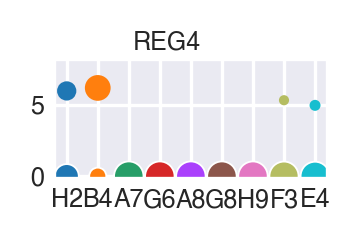

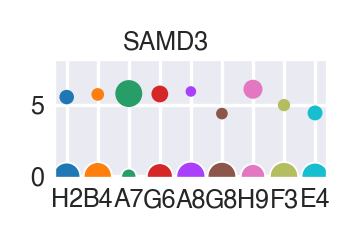

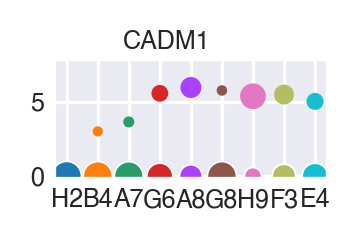

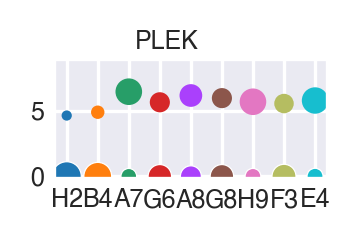

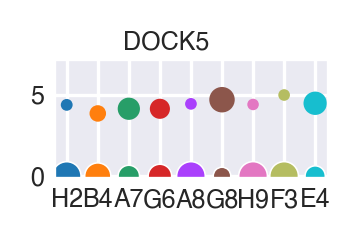

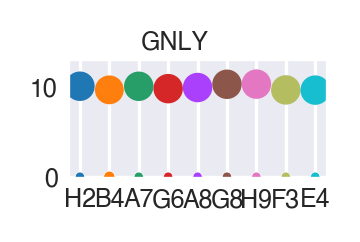

In [58]:
for gene in ['REG4', 'SAMD3', 'CADM1', 'PLEK','DOCK5','GNLY']:
    minivio_bin(gene, filename='Panels/ClonalGenes/'+gene+'_binary.pdf')

In [59]:
def minivio(gene, gf=X, mf = meta_df, prop='Clone_ID', hide_clones = False, show_ons = False,
               proporder=clones, clip = False, style='binary', filename=None):
    #if gn[:4] == 'ENSG':
    #    gene = gn
    #    genename = gene_names[gn]
    #else:
    #    gene = get_ensg(gn)
    #    genename = gn
    genename = gene   
    df = pd.DataFrame(gf[gene].copy())
    df[prop] = mf[prop]
    df_noclone = df.copy()
    df_noclone[prop] = 'All'
    #create a figure
    sns.set_style('whitegrid')
    fig,ax = plt.subplots(1,2,figsize=(30*mm,20*mm), dpi=300, sharey=True,
                         gridspec_kw={'width_ratios':[4,1],
                                     'wspace':0.05})
    setfontsize()
    ax[0].tick_params(axis='both', which='major', pad=-2)
    # ax.legend_.remove()
    
    if style == 'tune':
        genemean = df[gene].mean()
        genestd = df[gene].std()
        #ax[0].axhline(y=genemean, color='k', linestyle='-', alpha=0.5, linewidth=0.25)
        #ax[0].axhline(y=genemean+genestd, color='gray', linestyle=':', linewidth=0.25)
        #ax[0].axhline(y=genemean-genestd, color='gray', linestyle=':', linewidth=0.25)
        # Create the violin
        sns.violinplot(x=prop, y=gene, inner=None, scale='width', order=proporder, data=df, alpha=0.2, 
                       color='lightgray', linewidth=0.4, cut=0, ax=ax[0])
        sns.swarmplot(x=prop, y=gene, order=proporder, data=df, size=0.75, ax=ax[0])
        ax[0].set_ylim((max(df[gene].min() - 0.25,0), df[gene].max() + 0.25))
        #ax[0].set_ylim((max(df[gene].quantile(0.05) - 0.25,0), df[gene].max() + 0.25))
        
    elif style == 'binary':
        
        maxes = df.groupby(prop).max()[gene]
        nonzeros = df.groupby(prop).apply(lambda x : (x > np.log1p(10)).sum() / len(x))[gene]
        if show_ons:
            for x,clone in enumerate(clones):
                nz_label = int(nonzeros[clone]*100)
                if nz_label > 0:
                    ax.text(x, maxes[clone]+0.2, '{}%'.format(nz_label), 
                            ha='center', rotation=75) # '.{:0>2}'.format(int(nonzeros[clone]*100)), ha='center')
        #plt.axhline(y=log2p(10), color='k', linestyle='-', alpha=0.5, linewidth=0.25)
        #sns.violinplot(x=prop, y=gene, inner='stick', scale='width', order=proporder, data=df, 
        #               color='gray', saturation=0.2, 
        #               linewidth=0.4, cut=0, ax=ax[0])
        sns.violinplot(x=prop, y=gene, inner=None, scale='width', order=proporder, data=df, alpha=0.2, 
                       color='lightgray', linewidth=0.4, cut=0, ax=ax[0])
        sns.swarmplot(x=prop, y=gene, order=proporder, data=df, size=0.75, ax=ax[0])
        ax[0].set_ylim((-1, df[gene].max()*1.15))
    
    sns.violinplot(x=prop, y=gene, data=df_noclone, color='lightgray', width=1,
                   inner=None, saturation=0.8, linewidth=0.4, cut=0, ax=ax[1])
    sns.swarmplot(x=prop, y=gene, data=df_noclone, color='gray', size=0.75, ax=ax[1])
    
    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    ax[0].set_ylabel('')
    ax[1].set_ylabel('')
    ax[0].tick_params(axis='both', which='major', pad=-1)
    
    if hide_clones:
        ax[0].set_xticks([])
        ax[1].set_xticks([])
    #ax.set_xlabel('Clone')
    #ax.set_ylabel('$log_2({})$.'.format(genename))
    
    title_lines = ['{}'.format(genename)]
    fig.suptitle('\n '.join(title_lines),y=1.05)
    if filename:
        set_size(fig, (30*mm, 20*mm))
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

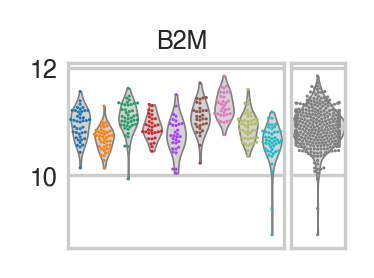

In [60]:
for gene in ['B2M']:
    minivio(gene, style='tune', hide_clones=True, show_ons = False)

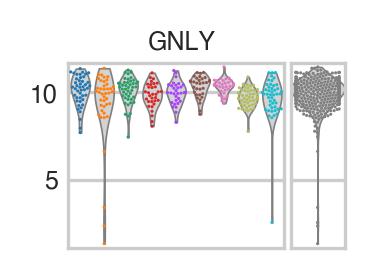

In [61]:
for gene in ['GNLY']:
    minivio(gene, style='tune', hide_clones=True, show_ons = False)

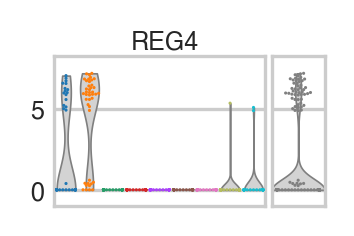

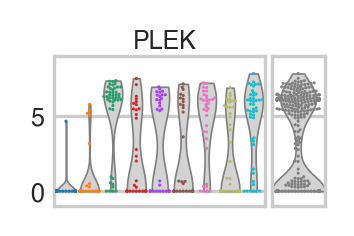

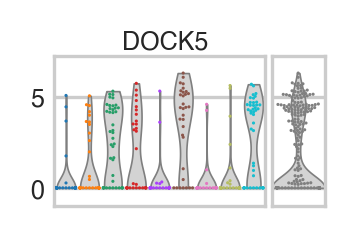

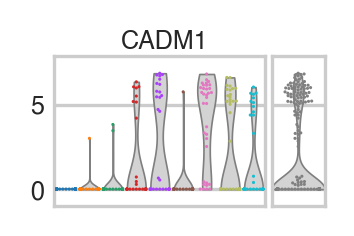

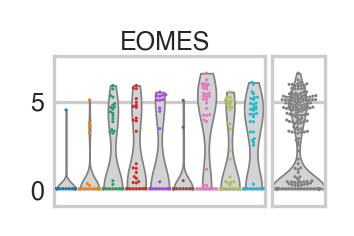

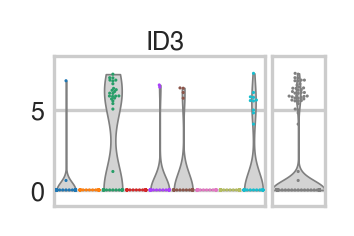

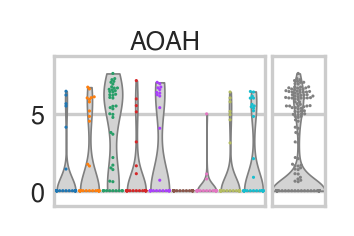

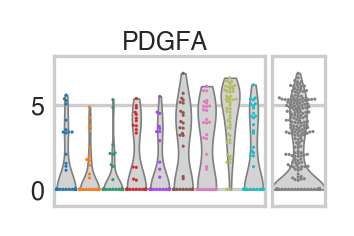

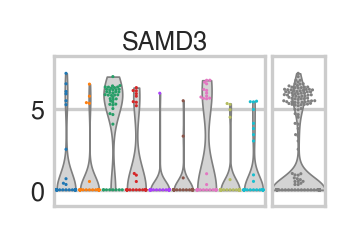

In [62]:
for gene in ['REG4','PLEK','DOCK5','CADM1','EOMES','ID3','AOAH','PDGFA','SAMD3']:
    minivio(gene, style='binary', hide_clones=True, show_ons = False,
            filename='Panels/ClonalGenes/'+gene+'_violin.pdf')

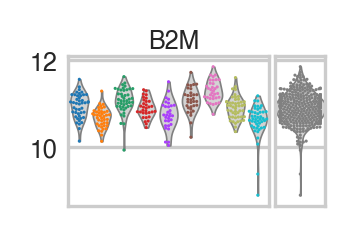

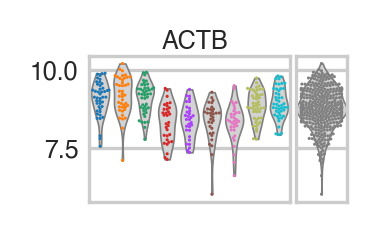

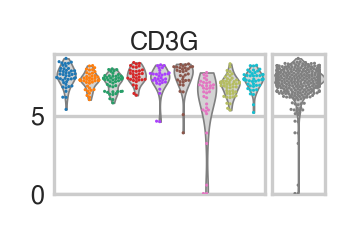

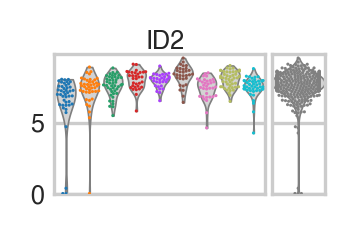

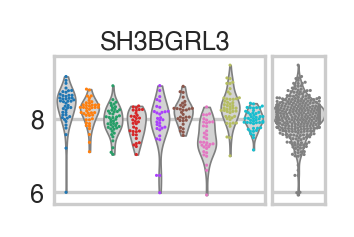

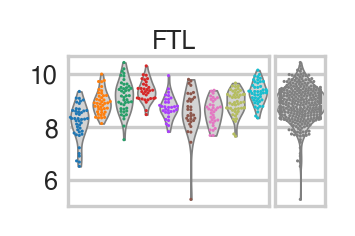

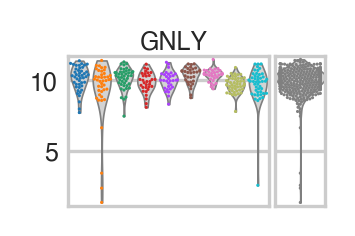

In [63]:
for gene in ['B2M', 'ACTB', 'CD3G', 'ID2', 'SH3BGRL3', 'FTL', 'GNLY']:
    minivio(gene, style='tune', hide_clones=True, show_ons = False,
            filename='Panels/ClonalGenes/'+gene+'_violin.pdf')